In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "24" 

import sys 
sys.path.insert(0, "/genesis/jwst/jwst-ref-soss/fortran_lib/transitfit/")   #pre-compiled Fortran library for python.

import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib
import matplotlib.pyplot  as plt

#Import module
import transitfit5 as tf #import transitfit5 modules
import tfit5 as tfit5 #Fortran-low-level modules

import math

from scipy.stats import binned_statistic #for binned data.

from tqdm.notebook import trange

#Modules for timing (not needed for production)
import time

In [2]:
WORKING_DIR = '/home/kmorel/ongenesis/jwst-user-soss/PHY3030/WASP_52/'

## Functions to move to external file.. 

In [3]:
class phot_class:
    def __init__(self):
        # Initialize arrays
        self.wavelength = []  # Wavelength of observation (should be a single number)
        self.time = []        # Time-stamps array -- mid-exposure time (days)
        self.flux = []        # Observed flux array 
        self.ferr = []        # Error in flux array
        self.itime = []       # Integration time (seconds)
        
class psg_class:
    def __init__(self):
        # Initialize arrays
        self.wavelength = []  # Wavelength of observation array
        self.flux = []        # Observed transit-depth due to atmosphere (ppm)
        self.ferr = []        # Predicted noise (ppm)
        
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1  # array[idx-1]
    else:
        return idx    # array[idx]
        
def read_model_planet(filename):
    '''
    Because Benneke's model not the same.
    # Reads in simple space delimited textfile.
    Reads in ',' delimited file
    '''
    data = []
    f = open(filename)
    icount = -1
    for line in f:
        line = line.strip()
        columns = line.split()  # Break into columns
        icount += 1
        if(icount > 0) & (columns[0]!='#') & (columns[0]!='wave,dppm,thermal'):  # Skip header info
            columns = line.split(',')
            data.append([float(i) for i in columns])
            #data.append(columns)
    f.close()
    return data

def read_model(filename):
    '''
    Reads in simple space delimited textfile.
    '''
    data = []
    f = open(filename)
    icount = -1
    for line in f:
        line = line.strip()
        columns = line.split()  # Break into columns
        icount += 1
        if(icount > 0) & (columns[0]!='#'):  # Skip header info
            data.append([float(i) for i in columns])
            #data.append(columns)
    f.close()
    return data

class sptransit_model_class(object):
    def __init__(self):
        self.wavelength = []     # Wavelength of each observation 
        
        self.rhostar = []        # Mean stellar density
        self.ld1 = []            # Limb-darkening. Set ld1=ld2=0 and ld3=q1 and ld4=q2
        self.ld2 = []  
        self.ld3 = []  
        self.ld4 = []  
        self.dilution = []       # Stellar dilution 0=none, 0.99 means 99% of light from other source
        self.zeropoint = []      # Out of transit baseline
        
        self.nplanet = 1         # Number of planets
        self.t0 = []             # Center of transit time
        self.period = []         # Orbital period
        self.b = []              # Impact parameter
        self.rprs = []           # Scale planet radius 
        self.sqrt_e_cosw = []    # sqrt(e)cos(w)
        self.sqrt_e_sinw = []    # sqrt(e)cos(w)
        self.eclipse_depth = []  # Secondard eclipse depth (ppm)
        self.ellipsoidal = []    # Amplitude of ellipsoidal variations (ppm)
        self.phasecurve = []     # Amplitude of reflected/emission phase curve (ppm) - Lambertian
        
        self.error_scale = []      # Scale to apply to photometric errors
        self.amplitude_scale = []  # GP Kernel Amplitude (default is Matern 3/2)
        self.length_scale = []     # GP length scale (default is Matern 3/2)
        
        self.ntt = []            # Parameters for TTVs ntt = number of transit times
        self.tobs = []           # Observed centre of transit times
        self.omc = []            # O-C values for eachtransit

class sptransit_model_parameters(sptransit_model_class):
    def __init__(self, num):
        sptransit_model_class.__init__(self)
        nwav = len(num[0])
        
        # Wavelength for each dataset
        zpt = []
        for p in num[0]:
            self.wavelength.append(p.wavelength)
            zpt.append(np.median(p.flux))
        zpt = np.array(zpt)
        
        # Star Parameters
        self.rhostar = [np.ones(1),'bolometric','fit',np.array([1.0e-4,1000])]     
        self.ld1 = [np.zeros(nwav),'chromatic','fixed',np.array([-1,1])]  
        self.ld2 = [np.zeros(nwav),'chromatic','fixed',np.array([-1,1])]  
        self.ld3 = [np.ones(nwav)*0.5,'chromatic','fit',np.array([0,1])]  
        self.ld4 = [np.ones(nwav)*0.5,'chromatic','fit',np.array([0,1])]  
        self.dilution = [np.zeros(nwav),'chromatic','fixed',np.array([0,1])]
        self.zeropoint = [zpt,'chromatic','fit',np.array([0,1.0e9])]
        
        # Planet Parameters
        nplanet = num[1]
        self.nplanet = num[1]*1
        for i in range(nplanet):
            self.t0.append([np.ones(1),'bolometric','fit',np.array([0,2])])
            self.period.append([np.ones(1),'bolometric','fit',np.array([0,2])])
            self.b.append([np.ones(1)*0.5,'bolometric','fit',np.array([0,2])])
            self.rprs.append([np.ones(nwav)*0.01,'chromatic','fit',np.array([0,1])])
            self.sqrt_e_cosw.append([np.zeros(1),'bolometric','fixed',np.array([-1,1])])
            self.sqrt_e_sinw.append([np.zeros(1),'bolometric','fixed',np.array([-1,1])])
            self.eclipse_depth.append([np.zeros(nwav),'chromatic','fixed',np.array([0,1.0e4])])
            self.ellipsoidal.append([np.zeros(nwav),'chromatic','fixed',np.array([0,1.0e4])])
            self.phasecurve.append([np.zeros(nwav),'chromatic','fixed',np.array([0,1.0e4])])
            
        # Error model
        self.error_scale = [np.ones(1)*1.0,'bolometric','fit',np.array([0,2])]
        self.amplitude_scale = [np.ones(nwav)*1.0,'chromatic','fixed',np.array([0,2000])]
        self.length_scale = [np.ones(nwav)*1.0,'chromatic','fixed',np.array([0,1])]
        
        self.ntt = 0
        self.tobs = 0
        self.omc = 0
        
        
def get_fitted_parameters(tpars):
    
    x = []
    
    if tpars.rhostar[2]=='fit':
        for p in tpars.rhostar[0]:
            x.append(p)
            
    if tpars.ld1[2]=='fit':
        for p in tpars.ld1[0]:
            x.append(p)
            
    if tpars.ld2[2]=='fit':
        for p in tpars.ld2[0]:
            x.append(p)
            
    if tpars.ld3[2]=='fit':
        for p in tpars.ld3[0]:
            x.append(p)
            
    if tpars.ld4[2]=='fit':
        for p in tpars.ld4[0]:
            x.append(p)
            
    if tpars.dilution[2]=='fit':
        for p in tpars.dilution[0]:
            x.append(p)
            
    if tpars.zeropoint[2]=='fit':
        for p in tpars.zeropoint[0]:
            x.append(p)
            
    for i in range(tpars.nplanet):
            
        if tpars.t0[i][2]=='fit':
            for p in tpars.t0[i][0]:
                x.append(p)
                
        if tpars.period[i][2]=='fit':
            for p in tpars.period[i][0]:
                x.append(p)
                
        if tpars.b[i][2]=='fit':
            for p in tpars.b[i][0]:
                x.append(p)
                
        if tpars.rprs[i][2]=='fit':
            for p in tpars.rprs[i][0]:
                x.append(p)
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            for p in tpars.sqrt_e_cosw[i][0]:
                x.append(p)
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            for p in tpars.sqrt_e_sinw[i][0]:
                x.append(p)
        
        if tpars.eclipse_depth[i][2]=='fit':
            for p in tpars.eclipse_depth[i][0]:
                x.append(p)
        
        if tpars.ellipsoidal[i][2]=='fit':
            for p in tpars.ellipsoidal[i][0]:
                x.append(p)
                
        if tpars.phasecurve[i][2]=='fit':
            for p in tpars.phasecurve[i][0]:
                x.append(p)
                
    if tpars.error_scale[2]=='fit':
        for p in tpars.error_scale[0]:
            x.append(p)
            
    if tpars.amplitude_scale[2]=='fit':
        for p in tpars.amplitude_scale[0]:
            x.append(p)
            
    if tpars.length_scale[2]=='fit':
        for p in tpars.length_scale[0]:
            x.append(p)
        
    x = np.array(x)
    
    return x

def get_all_parameters(tpars, photospectra):
    
    nhp = 3  # Potential number of hyper-parameters
    
    npars = 8 + 10*tpars.nplanet + nhp
    nwav = len(photospectra)
    
    sol = np.zeros([npars, nwav])
    
    if tpars.rhostar[1]=='bolometric':
        sol[0][:] = np.ones(nwav)*tpars.rhostar[0][0]
    else:
        sol[0][:] = tpars.rhostar[0]
        
    if tpars.ld1[1]=='bolometric':
        sol[1][:] = np.ones(nwav)*tpars.ld1[0][0]
    else:
        sol[1][:] = tpars.ld1[0]
        
    if tpars.ld2[1]=='bolometric':
        sol[2][:] = np.ones(nwav)*tpars.ld2[0][0]
    else:
        sol[2][:] = tpars.ld2[0]
        
    if tpars.ld3[1]=='bolometric':
        sol[3][:] = np.ones(nwav)*tpars.ld3[0][0]
    else:
        sol[3][:] = tpars.ld3[0]
        
    if tpars.ld4[1]=='bolometric':
        sol[4][:] = np.ones(nwav)*tpars.ld4[0][0]
    else:
        sol[4][:] = tpars.ld4[0]
        
    if tpars.dilution[1]=='bolometric':
        sol[5][:] = np.ones(nwav)*tpars.dilution[0][0]
    else:
        sol[5][:] = tpars.dilution[0]
        
    if tpars.zeropoint[1]=='bolometric':
        sol[7][:] = np.ones(nwav)*tpars.zeropoint[0][0]
    else:
        sol[7][:] = tpars.zeropoint[0]
        
    for i in range(tpars.nplanet):
        nc = 10*i
        
        if tpars.t0[i][1]=='bolometric':
            sol[8+nc][:] = np.ones(nwav)*tpars.t0[i][0][0]
        else:
            sol[8+nc][:] = tpars.t0[i][0]
            
        if tpars.period[i][1]=='bolometric':
            sol[9+nc][:] = np.ones(nwav)*tpars.period[i][0][0]
        else:
            sol[9+nc][:] = tpars.period[i][0]
            
        if tpars.b[i][1]=='bolometric':
            sol[10+nc][:] = np.ones(nwav)*tpars.b[i][0][0]
        else:
            sol[10+nc][:] = tpars.b[i][0]
            
        if tpars.rprs[i][1]=='bolometric':
            sol[11+nc][:] = np.ones(nwav)*tpars.rprs[i][0][0]
        else:
            sol[11+nc][:] = tpars.rprs[i][0]
            
        if tpars.sqrt_e_cosw[i][1]=='bolometric':
            sol[12+nc][:] = np.ones(nwav)*tpars.sqrt_e_cosw[i][0][0]
        else:
            sol[12+nc][:] = tpars.sqrt_e_cosw[i][0]
            
        if tpars.sqrt_e_sinw[i][1]=='bolometric':
            sol[13+nc][:] = np.ones(nwav)*tpars.sqrt_e_sinw[i][0][0]
        else:
            sol[13+nc][:] = tpars.sqrt_e_sinw[i][0]
            
        if tpars.eclipse_depth[i][1]=='bolometric':
            sol[15+nc][:] = np.ones(nwav)*tpars.eclipse_depth[i][0][0]
        else:
            sol[15+nc][:] = tpars.eclipse_depth[i][0]
            
        if tpars.ellipsoidal[i][1]=='bolometric':
            sol[16+nc][:] = np.ones(nwav)*tpars.ellipsoidal[i][0][0]
        else:
            sol[16+nc][:] = tpars.ellipsoidal[i][0]
        
        if tpars.phasecurve[i][1]=='bolometric':
            sol[17+nc][:] = np.ones(nwav)*tpars.phasecurve[i][0][0]
        else:
            sol[17+nc][:] = tpars.phasecurve[i][0]
    
    if tpars.error_scale[2]=='fit':
        if tpars.error_scale[1]=='bolometric':
            sol[npars-3][:]=np.ones(nwav)*tpars.error_scale[0][0]
        else:
            sol[npars-3][:]=tpars.error_scale[0]
            
    if tpars.amplitude_scale[2]=='fit':
        if tpars.amplitude_scale[1]=='bolometric':
            sol[npars-2][:]=np.ones(nwav)*tpars.amplitude_scale[0][0]
        else:
            sol[npars-2][:]=tpars.amplitude_scale[0]
            
    if tpars.length_scale[2]=='fit':
        if tpars.length_scale[1]=='bolometric':
            sol[npars-2][:]=np.ones(nwav)*tpars.length_scale[0][0]
        else:
            sol[npars-2][:]=tpars.length_scale[0]
    
    return sol

def update_sol(tpars, x, sol):
    '''
    Uses tpars and x to make an parameter set that will work with our transit model.
    '''
    
    solnew=np.copy(sol) #make a copy of the input sol array.
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
    
    xc=0 #counts position as we work through the x array.
    
    if tpars.rhostar[2]=='fit':
        if tpars.rhostar[1]=='bolometric':
            solnew[0][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[0][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld1[2]=='fit':
        if tpars.ld1[1]=='bolometric':
            solnew[1][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[1][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld2[2]=='fit':
        if tpars.ld2[1]=='bolometric':
            solnew[2][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[2][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld3[2]=='fit':
        if tpars.ld3[1]=='bolometric':
            solnew[3][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[3][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.ld4[2]=='fit':
        if tpars.ld4[1]=='bolometric':
            solnew[4][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[4][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.dilution[2]=='fit':
        if tpars.dilution[1]=='bolometric':
            solnew[5][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[5][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.zeropoint[2]=='fit':
        if tpars.zeropoint[1]=='bolometric':
            solnew[7][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[7][:]=x[xc:xc+nwav]
            xc+=nwav
            
    for i in range(tpars.nplanet):
        nc=10*i
        
        if tpars.t0[i][2]=='fit':
            if tpars.t0[i][1]=='bolometric':
                solnew[8+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[8+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.period[i][2]=='fit':
            if tpars.period[i][1]=='bolometric':
                solnew[9+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[9+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.b[i][2]=='fit':
            if tpars.b[i][1]=='bolometric':
                solnew[10+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[10+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.rprs[i][2]=='fit':
            if tpars.rprs[i][1]=='bolometric':
                solnew[11+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[11+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            if tpars.sqrt_e_cosw[i][1]=='bolometric':
                solnew[12+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[12+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            if tpars.sqrt_e_sinw[i][1]=='bolometric':
                solnew[13+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[13+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.eclipse_depth[i][2]=='fit':
            if tpars.eclipse_depth[i][1]=='bolometric':
                solnew[15+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[15+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.amplitude_scale[i][2]=='fit':
            if tpars.amplitude_scale[i][1]=='bolometric':
                solnew[16+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[16+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
        if tpars.length_scale[i][2]=='fit':
            if tpars.length_scale[i][1]=='bolometric':
                solnew[17+nc][:]=np.ones(nwav)*x[xc]
                xc+=1
            else:
                solnew[17+nc][:]=x[xc:xc+nwav]
                xc+=nwav
                
                
    if tpars.error_scale[2]=='fit':
        if tpars.error_scale[1]=='bolometric':
            solnew[npars-3][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[npars-3][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.amplitude_scale[2]=='fit':
        if tpars.amplitude_scale[1]=='bolometric':
            solnew[npars-2][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[npars-2][:]=x[xc:xc+nwav]
            xc+=nwav
            
    if tpars.length_scale[2]=='fit':
        if tpars.length_scale[1]=='bolometric':
            solnew[npars-2][:]=np.ones(nwav)*x[xc]
            xc+=1
        else:
            solnew[npars-2][:]=x[xc:xc+nwav]
            xc+=nwav           
    

    return solnew

def tran_ll_transform(cube):
    params = cube.copy() #cube contains random draws that need to be mapped to params 
    ncube=len(cube) #number of parameters that need to be mapped.
    
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
                
    xc=0 #counter to keep track of how many parmaters we have.
    
    if tpars.rhostar[2]=='fit':
        lo=tpars.rhostar[3][0]
        hi=tpars.rhostar[3][1]
        if tpars.rhostar[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld1[2]=='fit':
        lo=tpars.ld1[3][0]
        hi=tpars.ld1[3][1]
        if tpars.ld1[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld2[2]=='fit':
        lo=tpars.ld2[3][0]
        hi=tpars.ld2[3][1]
        if tpars.ld2[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld3[2]=='fit':
        lo=tpars.ld3[3][0]
        hi=tpars.ld3[3][1]
        if tpars.ld3[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.ld4[2]=='fit':
        lo=tpars.ld4[3][0]
        hi=tpars.ld4[3][1]
        if tpars.ld4[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.dilution[2]=='fit':
        lo=tpars.dilution[3][0]
        hi=tpars.dilution[3][1]
        if tpars.dilution[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.zeropoint[2]=='fit':
        lo=tpars.zeropoint[3][0]
        hi=tpars.zeropoint[3][1]
        if tpars.zeropoint[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    for i in range(tpars.nplanet):
        nc=10*i
        
        if tpars.t0[i][2]=='fit':
            lo=tpars.t0[i][3][0]
            hi=tpars.t0[i][3][1]
            if tpars.t0[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
        
        if tpars.period[i][2]=='fit':
            lo=tpars.period[i][3][0]
            hi=tpars.period[i][3][1]
            if tpars.period[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.b[i][2]=='fit':
            lo=tpars.b[i][3][0]
            hi=tpars.b[i][3][1]
            if tpars.b[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.rprs[i][2]=='fit':
            lo=tpars.rprs[i][3][0]
            hi=tpars.rprs[i][3][1]
            if tpars.rprs[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            lo=tpars.sqrt_e_cosw[i][3][0]
            hi=tpars.sqrt_e_cosw[i][3][1]
            if tpars.sqrt_e_cosw[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            lo=tpars.sqrt_e_sinw[i][3][0]
            hi=tpars.sqrt_e_sinw[i][3][1]
            if tpars.sqrt_e_sinw[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.eclipse_depth[i][2]=='fit':
            lo=tpars.eclipse_depth[i][3][0]
            hi=tpars.eclipse_depth[i][3][1]
            if tpars.eclipse_depth[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.amplitude_scale[i][2]=='fit':
            lo=tpars.amplitude_scale[i][3][0]
            hi=tpars.amplitude_scale[i][3][1]
            if tpars.amplitude_scale[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
        if tpars.length_scale[i][2]=='fit':
            lo=tpars.length_scale[i][3][0]
            hi=tpars.length_scale[i][3][1]
            if tpars.length_scale[i][1]=='bolometric':
                params[xc]=cube[xc] * (hi - lo) + lo
                xc+=1
            else:
                params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
                xc+=nwav
                
    if tpars.error_scale[2]=='fit':
        lo=tpars.error_scale[3][0]
        hi=tpars.error_scale[3][1]
        if tpars.error_scale[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.amplitude_scale[2]=='fit':
        lo=tpars.amplitude_scale[3][0]
        hi=tpars.amplitude_scale[3][1]
        if tpars.amplitude_scale[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
    if tpars.length_scale[2]=='fit':
        lo=tpars.length_scale[3][0]
        hi=tpars.length_scale[3][1]
        if tpars.length_scale[1]=='bolometric':
            params[xc]=cube[xc] * (hi - lo) + lo
            xc+=1
        else:
            params[xc:xc+nwav]=cube[xc:xc+nwav] * (hi - lo) + lo
            xc+=nwav
            
        
            
    return params

def get_names(clabels,tpars):
    '''Assign labels to all the parameters
    '''

    solnew=np.copy(sol) #make a copy of the input sol array.
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
    
    tran_par_names=[]
    
    if tpars.rhostar[2]=='fit':
        if tpars.rhostar[1]=='bolometric':
            tran_par_names.append(clabels[0])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[0])
            
    if tpars.ld1[2]=='fit':
        if tpars.ld1[1]=='bolometric':
            tran_par_names.append(clabels[1])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[1])
            
    if tpars.ld2[2]=='fit':
        if tpars.ld2[1]=='bolometric':
            tran_par_names.append(clabels[2])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[2])
            
    if tpars.ld3[2]=='fit':
        if tpars.ld3[1]=='bolometric':
            tran_par_names.append(clabels[3])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[3])
            
    if tpars.ld4[2]=='fit':
        if tpars.ld4[1]=='bolometric':
            tran_par_names.append(clabels[4])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[4])
            
    if tpars.dilution[2]=='fit':
        if tpars.dilution[1]=='bolometric':
            tran_par_names.append(clabels[5])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[5])
            
    if tpars.zeropoint[2]=='fit':
        if tpars.zeropoint[1]=='bolometric':
            tran_par_names.append(clabels[7])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[7])
            
    for i in range(tpars.nplanet):
        nc=10*i
        
        if tpars.t0[i][2]=='fit':
            if tpars.t0[i][1]=='bolometric':
                tran_par_names.append(clabels[8])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[8])
                
        if tpars.period[i][2]=='fit':
            if tpars.period[i][1]=='bolometric':
                tran_par_names.append(clabels[9])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[9])
                
        if tpars.b[i][2]=='fit':
            if tpars.b[i][1]=='bolometric':
                tran_par_names.append(clabels[10])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[10])
                
        if tpars.rprs[i][2]=='fit':
            if tpars.rprs[i][1]=='bolometric':
                tran_par_names.append(clabels[11])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[11])
                
        if tpars.sqrt_e_cosw[i][2]=='fit':
            if tpars.sqrt_e_cosw[i][1]=='bolometric':
                tran_par_names.append(clabels[12])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[12])
                
        if tpars.sqrt_e_sinw[i][2]=='fit':
            if tpars.sqrt_e_sinw[i][1]=='bolometric':
                tran_par_names.append(clabels[13])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[13])
                
        if tpars.eclipse_depth[i][2]=='fit':
            if tpars.eclipse_depth[i][1]=='bolometric':
                tran_par_names.append(clabels[15])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[15])
                
        if tpars.amplitude_scale[i][2]=='fit':
            if tpars.amplitude_scale[i][1]=='bolometric':
                tran_par_names.append(clabels[16])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[16])
                
        if tpars.length_scale[i][2]=='fit':
            if tpars.length_scale[i][1]=='bolometric':
                tran_par_names.append(clabels[17])
            else:
                for j in range(nwav):
                    tran_par_names.append(clabels[17])
                
                
    if tpars.error_scale[2]=='fit':
        if tpars.error_scale[1]=='bolometric':
            tran_par_names.append(clabels[18])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[18])
            
    if tpars.amplitude_scale[2]=='fit':
        if tpars.amplitude_scale[1]=='bolometric':
            tran_par_names.append(clabels[19])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[19])
            
    if tpars.length_scale[2]=='fit':
        if tpars.length_scale[1]=='bolometric':
            tran_par_names.append(clabels[20])
        else:
            for j in range(nwav):
                tran_par_names.append(clabels[20])
                
    return tran_par_names

def checksolution(tpars,solnew,badlpr):
    '''Make sure model parameters are valid.
    '''
    
    logl=1.0e0
    
    nwav=sol.shape[1] #number of bandpasses
    npars=sol.shape[0] #number of model parameters
    
    for i in range(nwav):
        sol1=np.array([s[i] for s in solnew])
        
        
        if tpars.rhostar[2]=='fit':
            lo=tpars.rhostar[3][0]
            hi=tpars.rhostar[3][1]
            if (sol1[0]>hi)|(sol1[0]<lo):
                logl=badlpr
                
        if tpars.ld1[2]=='fit':
            lo=tpars.ld1[3][0]
            hi=tpars.ld1[3][1]
            if (sol1[1]>hi)|(sol1[1]<lo):
                logl=badlpr
              
        if tpars.ld2[2]=='fit':
            lo=tpars.ld2[3][0]
            hi=tpars.ld2[3][1]
            if (sol1[2]>hi)|(sol1[2]<lo):
                logl=badlpr
          
        if tpars.ld3[2]=='fit':
            lo=tpars.ld3[3][0]
            hi=tpars.ld3[3][1]
            if (sol1[3]>hi)|(sol1[3]<lo):
                logl=badlpr
               
        if tpars.ld4[2]=='fit':
            lo=tpars.ld4[3][0]
            hi=tpars.ld4[3][1]
            if (sol1[4]>hi)|(sol1[4]<lo):
                logl=badlpr
             
        if tpars.dilution[2]=='fit':
            lo=tpars.dilution[3][0]
            hi=tpars.dilution[3][1]
            if (sol1[5]>hi)|(sol1[5]<lo):
                logl=badlpr
             
        if tpars.zeropoint[2]=='fit':
            lo=tpars.zeropoint[3][0]
            hi=tpars.zeropoint[3][1]
            if (sol1[7]>hi)|(sol1[7]<lo):
                logl=badlpr
              
        for i in range(tpars.nplanet):
            nc=10*i
            
            if tpars.t0[i][2]=='fit':
                lo=tpars.t0[i][3][0]
                hi=tpars.t0[i][3][1]
                if (sol1[8+nc]>hi)|(sol1[8+nc]<lo):
                    logl=badlpr
                   
            if tpars.period[i][2]=='fit':
                lo=tpars.period[i][3][0]
                hi=tpars.period[i][3][1]
                if (sol1[9+nc]>hi)|(sol1[9+nc]<lo):
                    logl=badlpr
                 
            if tpars.b[i][2]=='fit':
                lo=tpars.b[i][3][0]
                hi=tpars.b[i][3][1]
                if (sol1[10+nc]>hi)|(sol1[10+nc]<lo):
                    logl=badlpr
                  
            if tpars.rprs[i][2]=='fit':
                lo=tpars.rprs[i][3][0]
                hi=tpars.rprs[i][3][1]
                if (sol1[11+nc]>hi)|(sol1[11+nc]<lo):
                    logl=badlpr
                  
            if tpars.sqrt_e_cosw[i][2]=='fit':
                lo=tpars.sqrt_e_cosw[i][3][0]
                hi=tpars.sqrt_e_cosw[i][3][1]
                if (sol1[12+nc]>hi)|(sol1[12+nc]<lo):
                    logl=badlpr
                  
            if tpars.sqrt_e_sinw[i][2]=='fit':
                lo=tpars.sqrt_e_sinw[i][3][0]
                hi=tpars.sqrt_e_sinw[i][3][1]
                if (sol1[13+nc]>hi)|(sol1[13+nc]<lo):
                    logl=badlpr
                  
            if tpars.eclipse_depth[i][2]=='fit':
                lo=tpars.eclipse_depth[i][3][0]
                hi=tpars.eclipse_depth[i][3][1]
                if (sol1[15+nc]>hi)|(sol1[15+nc]<lo):
                    logl=badlpr
                  
            if tpars.amplitude_scale[i][2]=='fit':
                lo=tpars.amplitude_scale[i][3][0]
                hi=tpars.amplitude_scale[i][3][1]
                if (sol1[15+nc]>hi)|(sol1[15+nc]<lo):
                    logl=badlpr
                   
            if tpars.length_scale[i][2]=='fit':
                lo=tpars.length_scale[i][3][0]
                hi=tpars.length_scale[i][3][1]
                if (sol1[15+nc]>hi)|(sol1[15+nc]<lo):
                    logl=badlpr
                
        if tpars.error_scale[2]=='fit':
            lo=tpars.error_scale[3][0]
            hi=tpars.error_scale[3][1]
            if (sol1[npars-3]>hi)|(sol1[npars-3]<lo):
                logl=badlpr
               
        if tpars.amplitude_scale[2]=='fit':
            lo=tpars.amplitude_scale[3][0]
            hi=tpars.amplitude_scale[3][1]
            if (sol1[npars-2]>hi)|(sol1[npars-2]<lo):
                logl=badlpr
                
        if tpars.length_scale[2]=='fit':
            lo=tpars.length_scale[3][0]
            hi=tpars.length_scale[3][1]
            if (sol1[npars-1]>hi)|(sol1[npars-1]<lo):
                logl=badlpr

    return logl

In [4]:
def gelmanrubin(*chain, burnin, npt):
    # See pdf doc BrooksGelman for info
    "Estimating PSRF"
    M = len(chain)                    # Number of chains
    N = chain[0].shape[0]-burnin      # Assuming all chains have the same size.
    npars = chain[0].shape[1]         # Number of parameters
    pmean = np.zeros(shape=(M,npars)) # Allocate array to hold mean calculations 
    pvar = np.zeros(shape=(M,npars))  # Allocate array to hold variance calculations

    for i in range(0, M):
        currentchain = chain[i]
        for j in range(0, npars):
            pmean[i,j] = np.mean(currentchain[burnin:,j]) # Generate means for each parameter in each chain
            pvar[i,j] = np.var(currentchain[burnin:,j])   # Generate variance for each parameter in each chain
    
    posteriormean = np.zeros(npars)  # Allocate array for posterior means
    for j in range(0, npars):
        posteriormean[j] = np.mean(pmean[:,j])  # Calculate posterior mean for each parameter
        
    # Calculate between chains variance
    B = np.zeros(npars)
    for j in range(0, npars):
        for i in range(0, M):
            B[j] += np.power((pmean[i,j]-posteriormean[j]),2)
    B = B*N/(M-1.0)    
    
    # Calculate within chain variance
    W = np.zeros(npars)
    for j in range(0, npars):
        for i in range(0, M):
            W[j] += pvar[i,j]
    W = W/M 
    
    
    #Calculate the pooled variance
    V = (N-1)*W/N + (M+1)*B/(M*N)
    
    dof = npt-1   # Degrees of freedom 
    Rc = np.sqrt((dof+3.0)/(dof+1.0)*V/W)   # PSRF from Brooks and Gelman (1997)
    
    #Calculate Ru
    #qa=0.95
    #ru=np.sqrt((dof+3.0)/(dof+1.0)*((N-1.0)/N*W+(M+1.0)/M*qa))
    
    return Rc;

def demhmcmc(x, llx, loglikelihood, beta, buffer, corbeta):
    "A Metropolis-Hastings MCMC with Gibbs sampler"
    
    nbuffer = len(buffer[:,0])
    rsamp = np.random.rand() #draw a random number to decide which sampler to use
    
    if rsamp < 0.5: #if rsamp is less than 0.5 use a Gibbs sampler 

        xt=np.copy(x)                            #make a copy of our current state to the trail state
        npars=len(x)                             #number of parameters
        n=int(np.random.rand()*npars)            #random select a parameter to vary.
    
        xt[n]=xt[n]+np.random.normal(0.0,beta[n])#Step 2: Generate trial state with Gibbs sampler 

    else:   #use our deMCMC sampler

        n=-1 #tell the accept array that we used the deMCMC sampler
        i1=int(np.random.rand()*nbuffer)
        i2=int(np.random.rand()*nbuffer)
        vectorjump=buffer[i1,:]-buffer[i2,:]
        xt=x+vectorjump*corbeta
    
    llxt=loglikelihood(xt) #Step 3 Compute log(p(x'|d))=log(p(x'))+log(p(d|x'))
    
    alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability
    
    u=np.random.rand()                       #Step 5 generate a random number

    if u <= alpha:                           #Step 6, compare u and alpha
        xp1=np.copy(xt)                      #accept new trial
        llxp1=np.copy(llxt)
        ac=[0, n]                             #Set ac to mark acceptance
    else:
        xp1=np.copy(x)                       #reject new trial
        llxp1=np.copy(llx)
        ac=[1, n]                             #Set ac to mark rejectance
        
    xp1=np.array(xp1)
    return xp1,llxp1,ac;    

def betarescale(x,beta,niter,burnin,mcmcfunc,loglikelihood,imax=20):
    "Calculate rescaling of beta to improve acceptance rates"
    
    alow = 0.22  #alow, ahigh define the acceptance rate range we want
    ahigh = 0.28
    
    delta=0.01  #parameter controling how fast corscale changes - from Gregory 2011.
    
    npars=len(x)   #Number of parameters
    acorsub=np.zeros(npars) 
    nacor=np.zeros(npars)       #total number of accepted proposals
    nacorsub=np.zeros(npars)    #total number of accepted proposals immediately prior to rescaling
    npropp=np.zeros(npars)      #total number of proposals
    nproppsub=np.zeros(npars)   #total number of proposals immediately prior to rescaling
    acrate=np.zeros(npars)      #current acrate 
    corscale=np.ones(npars)
    
    #inital run
    chain,accept=genchain(x,niter,beta,mcmcfunc,loglikelihood) #Get a MC   
    nchain=len(chain[:,0])
    
    #calcalate initial values of npropp and nacor 
    for i in range(burnin,nchain):
        j=accept[i,1]           #get accept flag value
        npropp[j]+=1            #update total number of proposals
        nacor[j]+=1-accept[i,0] #update total number of accepted proposals
        
    #update x
    xin=chain[niter,:]  #we can continue to make chains by feeding the current state back into genchain
    
    acrate=nacor/npropp #inital acceptance rate
    
    afix=np.ones(npars)  #afix is an integer flag to indicate which beta entries need to be updated
    for i in range(0,npars):
        if (acrate[i]<ahigh)&(acrate[i]>alow):   #we strive for an acceptance rate between alow,ahigh
            afix[i]=0    #afix=1 : update beta, afix=0 : do not update beta

    #We will iterate a maximum of imax times - avoid infinite loops
    icount=0   #counter to track iterations
    while (np.sum(afix) > 0):
        icount+=1  #track number of iterations
        
        if icount>1:
            npropp=np.copy(nproppsub)
            nacor=np.copy(nacorsub)
        nacorsub=np.zeros(npars)  #reset nacorsub counts for each loop
        nproppsub=np.zeros(npars) #reset nproppsub counts for each loop
        
        #Make another chain starting with xin
        betain=beta*corscale   #New beta for Gibbs sampling  
        chain,accept=genchain(xin,niter,betain,mcmcfunc,loglikelihood) #Get a MC
        xin=chain[niter,:]     #Store current parameter state 
        
        for i in range(burnin,nchain): #scan through Markov-Chains and count number of states and acceptances 
            j=accept[i,1]
            #if acrate[j]>ahigh or acrate[j]<alow: 
            npropp[j]+=1            #update total number of proposals
            nacor[j]+=1-accept[i,0] #update total number of accepted proposals
            nproppsub[j]+=1            #Update current number of proposals
            nacorsub[j]+=1-accept[i,0] #Update current number of accepted proposals

        for i in range(0,npars):  #calculate acceptance rates for each parameter that is to updated 
            #calculate current acrates
            acrate[i]=nacorsub[i]/nproppsub[i]

            #calculate acorsub
            acorsub[i]=(nacor[i]-nacorsub[i])/(npropp[i]-nproppsub[i])
    
            if afix[i]>0:
                #calculate corscale
                corscale[i]=np.abs(corscale[i]*np.power((acorsub[i]+delta)\
                                                        *0.75/(0.25*(1.0-acorsub[i]+delta)) ,0.25))
        
        print('Current Acceptance: ',acrate) #report acceptance rates
        for i in range(0,npars):  #check which parameters have achieved required acceptance rate
            if acrate[i]<ahigh and acrate[i]>alow:
                afix[i]=0

        if(icount>imax):   #if too many iterations, then we give up and exit
            afix=np.zeros(npars)
            print("Too many iterations: icount > imax")
    
    print('Final Acceptance: ',acrate) #report acceptance rates
    
    return corscale;

def calcacrate(accept,burnin):#,label):
    "Calculate Acceptance Rates"
    nchain=len(accept[:,0])
    print ('%s %.3f' % ('Global Acceptance Rate:',(nchain-burnin-np.sum(accept[burnin:,0]))/(nchain-burnin)))

    for j in range(max(accept[burnin:,1])+1):
        denprop=0   #this is for deMCMC
        deacrate=0  #this is for deMCMC
        
        nprop=0   #number of proposals
        acrate=0  #acceptance rate
        
        for i in range(burnin,nchain): #scan through the chain.
            if accept[i,1] == j :
                nprop=nprop+1
                acrate=acrate+accept[i,0]
            if accept[i,1] == -1 :
                denprop=denprop+1
                deacrate=deacrate+accept[i,0]
                
        #print('%s Acceptance Rate %.3f' % (label[j],(nprop-acrate)/nprop))
        print('%s Acceptance Rate %.3f' % (str(j),(nprop-acrate)/(nprop+1)))
    
    #if we have deMCMC results, report the acceptance rate.
    if denprop > 0:
        print('%s Acceptance Rate %.3f' % ('deMCMC',(denprop-deacrate)/denprop))
        
    return;


def genchain(x,niter,beta,mcmcfunc,loglikelihood,buffer=[],corbeta=1,progress=False): 
    """Generate Markov Chain
    x - starting model parameters
    
    All variables needed by mcmcfunc are passed 
    
    returns: chain, accept
        chain - Markov-Chain dimensions [npars,iter]
        accept - tracking acceptance
    """
    chain=[]                                  #Initialize list to hold chain values
    accept=[]                                 #Track our acceptance rate
    chain.append(x)                           #Step 1: start the chain
    accept.append((0,0))                      #track acceptance rates for each parameter
    llx=loglikelihood(x)                      #pre-compute the log-likelihood for Step 3
    

    if progress==True:
        for i in trange(0,niter):
            x,llx,ac = mcmcfunc(x,llx,loglikelihood,beta,buffer,corbeta)
            chain.append(x)
            accept.append(ac)
    else:
        for i in range(0,niter):
            x,llx,ac = mcmcfunc(x,llx,loglikelihood,beta,buffer,corbeta)
            chain.append(x)
            accept.append(ac)

        
    chain=np.array(chain)                     #Convert list to array
    accept=np.array(accept)
    
    return chain, accept;

def mhgmcmc(x,llx,loglikelihood,beta,buffer=[],corbeta=1):
    """A Metropolis-Hastings MCMC with Gibbs sampler
    x - np.array : independent variable
    llx - real : previous value of logL
    loglikeihood : returns log-likelihood
    beta - Gibb's factor : characteristic step size
    
    buffer - used when we discuss deMCMC
    
    returns: xp1,llxp1,ac
      xpl - next state (new parameters)
      llxp1 - log-likelihood of new state
      ac - if trial state was accepted or rejected.
    """
    
    xt=np.copy(x)                            #make a copy of our current state to the trail state
    npars=len(x)                             #number of parameters
    n=int(np.random.rand()*npars)            #random select a parameter to vary.
    
    xt[n]+=np.random.normal(0.0,beta[n])     #Step 2: Generate trial state with Gibbs sampler 
    
    llxt=loglikelihood(xt)                   #Step 3 Compute log(p(x'|d))=log(p(x'))+log(p(d|x'))

    alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability
    
    u=np.random.rand()                       #Step 5 generate a random number

    if u <= alpha:                           #Step 6, compare u and alpha
        xp1=np.copy(xt)                      #accept new trial
        llxp1=np.copy(llxt)
        ac=[0, n]                            #Set ac to mark acceptance
    else:
        xp1=np.copy(x)                       #reject new trial
        llxp1=np.copy(llx)
        ac=[1, n]                            #Set ac to mark rejectance
        
    return xp1,llxp1,ac;                     #return new state and log(p(x|d)) 

def plotchains(chain,burnin,label):
    
    npars=chain.shape[1]
    fig,ax = plt.subplots(nrows=npars,figsize=(12,1.5*npars))
    for i in range(npars):
        #fig[i].subplot(npars, 1, i+1)
        ax[i].plot(chain[burnin:,i])#,c=colour[i])
        ax[i].tick_params(direction='in', length=10, width=2)
        ax[i].set_ylabel(label[i])
        if i+1 < npars:
            ax[i].set_xticklabels([])
        
    plt.show()

## Create Synthetic data

primarly purpose is to highlight data format expected.
We will use PSG, for the input model, but any model will work.

In [5]:
model_dir = '/genesis/jwst/jwst-ref-soss/planet_model_atm/'
model_name = 'WASP_52_b_HR_Metallicity100_CtoO0.54_pQuench1e-99_TpNonGrayTint75.0f0.25A0.1_pCloud100000.0mbar_Spectrum_FullRes.csv'

In [7]:
# WASP-52b simulation

# Wavelengths [um]
wl = np.load(WORKING_DIR + 'wavelengths.npy')
# Extracted normalized flux
extracted_flux = np.load(WORKING_DIR + 'extracted_flux_norm.npy')
# Array of time [Days]
time_obs = np.load(WORKING_DIR + 'time_array.npy') / 60. / 24.
# Noise (flux error)
noise = np.load(WORKING_DIR + 'phot_noise.npy')

# Wavelengths are put in order
wl = wl[::-1]
extracted_flux = extracted_flux[:,::-1]
noise = noise[:,::-1]

wl = np.nan_to_num(wl)
extracted_flux = np.nan_to_num(extracted_flux)
noise = np.nan_to_num(noise)

<ipython-input-8-1fccd468b5fb>:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


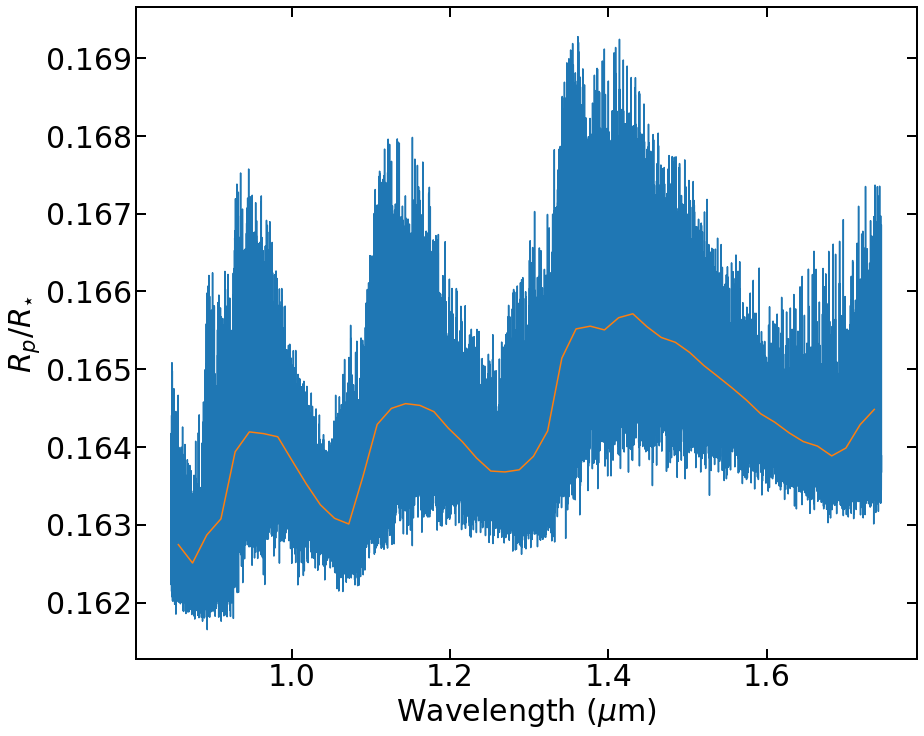

In [8]:
matplotlib.rcParams.update({'font.size': 30})   # adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig = plt.figure(figsize=(14,12))  # adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)

ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('$R_{p}/R_{\star}$')

# Read in spectrum model
model_data = read_model_planet(model_dir + model_name)

# Get wavelength and transit depth info
wl_model = np.array([float(d[0]) for d in model_data])   # Wavelength in microns
RpRs_model = np.array([np.sqrt(float(d[1])/1.0e6) for d in model_data])   # Rp/Rs

# Keep same wavelength range for model and data
ind_wl = (wl_model>=wl[0])*(wl_model<=wl[-1])
wl_model = wl_model[ind_wl]
wl_nobin = np.copy(wl_model)
RpRs_model = RpRs_model[ind_wl]
RpRs_nobin = np.copy(RpRs_model)

ax.plot(wl_model, RpRs_model)

# Let's bin the data
nbins = 50

bin_means1 = binned_statistic(wl_model, RpRs_model, bins=nbins)

bin_wave = []
bin_RpRs = []

for i in range(nbins):
    bin_wave.append((bin_means1[1][i]+bin_means1[1][i+1])/2)
    bin_RpRs.append(bin_means1[0][i])
bin_wave = np.array(bin_wave)
bin_RpRs = np.array(bin_RpRs)

wl_model = bin_wave
RpRs_model = bin_RpRs

ax.plot(wl_model, RpRs_model)

fig.show()

In [9]:
# For first tests, we want to use only a few transit curves
nb_wl = 30   # Number of wavelengths to keep
wl_test = []
extracted_flux_test = []
noise_test = []

for i in range(nb_wl):
    wl_test.append(wl[i*len(wl)//nb_wl])
    extracted_flux_test.append(extracted_flux[:, i*len(wl)//nb_wl])
    noise_test.append(noise[:, i*len(wl)//nb_wl])
# New shortened arrays
wl_test = np.array(wl_test)
extracted_flux_test = np.array(extracted_flux_test)

In [10]:
obstime = time_obs   # Array of observation time [days]
itime = np.ones(len(obstime))*76.916 / 60. / 60. / 24.   # Integration time [days]

# List to store data
photospectra = []    # Will contain all the observations
   
rprs_binned = RpRs_model   # We will save the input r/R* values to compare later.

# Loop over atmosphere model
# for i in range(len(wl)):                  
for i in range(len(wl_test)):
    
    # Wasp_52b simulation
    phot = phot_class()  # Each wavelength has its class (arrays)
    phot.wavelength = np.copy(wl_test[i])   
    phot.time = np.copy(obstime)
#    phot.flux = np.copy(extracted_flux[:, i])   # Normalized extracted flux      
    phot.flux = np.copy(extracted_flux_test[i])
#    phot.ferr = np.copy(noise[:, i])
    phot.ferr = np.copy(noise_test[i])
    phot.itime = np.copy(itime)

    photospectra.append(phot)  # Stores phot. class

<ipython-input-11-49a48683cbe5>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


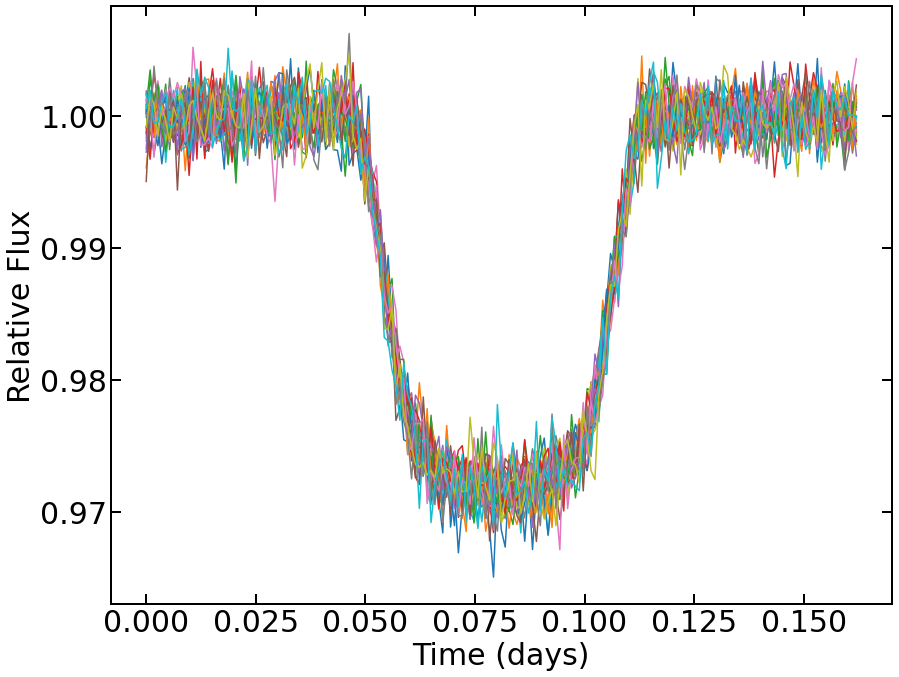

In [11]:
#Show a plot of the data.  Each colour is a different wavelength.
matplotlib.rcParams.update({'font.size': 30})  # Adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig = plt.figure(figsize=(14,11))  # Adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)

ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_xlabel('Time (days)')
ax.set_ylabel('Relative Flux')

for p in photospectra:
    ax.plot(p.time, p.flux)
fig.savefig(WORKING_DIR + "transit_curves.png")
fig.show()

## Let's fit the multi-spectrum model

In [87]:
# Number of planets to include
nplanet = 1

# Set up default parameters 
tpars = sptransit_model_parameters([photospectra, nplanet])

# Fill in a few necessary parameters 
# (Overwrites default parameters that were given in def)
tpars.rhostar[0] = np.array([2.48])       # [g/cm³]  
tpars.rhostar[3] = np.array([0.9, 6.0])   # boundaries for valid models, if needed.    

tpars.period[0][0] = np.array([1.7497798])  # [days]
tpars.period[0][2] = 'fixed'

tpars.t0[0][0] = np.array([0.08])   # t0: center of transit time 
tpars.t0[0][3] = np.array([0.08-0.03,0.08+0.03])

tpars.b[0][0] = np.array([0.6])  # impact parameter
tpars.b[0][3] = np.array([0.4, 0.8])

tpars.rprs[0][0] = np.ones(len(photospectra))*0.1645  # Rp/Rs
tpars.rprs[0][3] = np.array([0.1,0.2])

tpars.zeropoint[0] = np.full(len(photospectra), 0.001)  # is added to transit curve
tpars.zeropoint[3] = np.array([0.995-1.,1.01-1.])

# Simple labels to identify parameters.
clabels = ['p','c1','c2','q1','q2','DIL','VOF','ZPT','EP','PE','BB','RD','EC','ES','KRV','TED','ELL','ALB',\
        'DSC','ASC','LSC']

In [88]:
def lnprob(x):
    ''' 
    ln prob model
    Nested sampling and many MCMC routines use global variables.  Thus, only the fitted parameters are passed.
    Fitted parameters are contained in the input 'x' array.
    '''
    
    logl = 1.0e0   # initialize log-likelihood to some value.
    # check validity of array
    badlpr = -np.inf   # if outside bounds, then mark poor likelihood.
    
    nwav = sol.shape[1]  # number of bandpasses
    npars = sol.shape[0] # number of model parameters
    
    solnew = update_sol(tpars,x,sol)  # contains sol but updated with values from 'x'
    
    # check validity of array
    logl = checksolution(tpars,solnew,badlpr)

    if logl>badlpr:
    
        for i in range(nwav):
            dscale = solnew[npars-3][i]   # photometric scale
            ascale = solnew[npars-2][i]   # photometric scale
            lscale = solnew[npars-1][i]   # length scale for GP

            # check dscale, ascale and lscale hyper parameters (they must be positive)
            if (dscale <= 0.0) & (tpars.error_scale[2]=='fit'):
                logl = badlpr
            if (ascale <= 0.0) & (tpars.amplitude_scale[2]=='fit'):
                logl = badlpr
            if (lscale <= 0.0) & (tpars.length_scale[2]=='fit'):
                logl = badlpr

            if (tpars.amplitude_scale[2]=='fit')|(tpars.length_scale[2]=='fit'):
                modeltype = 1   # GP model
            else:
                modeltype = 0   # uncorrelated noise model

            npt = len(photospectra[i].time)   # number of data points

            sol1 = np.array([s[i] for s in solnew])

            # zpt=np.copy(sol1[7])
            sol1[7] -= 1.0 
            
            if logl>badlpr:  # check that we have a valid model to use
                # Retrieve transit model using sol3 array 
                ans = tf.transitmodel(sol1, photospectra[i].time, itime=photospectra[i].itime, \
                                       ntt=tpars.ntt, tobs=tpars.tobs, omc=tpars.omc)
                #ans = ans*zpt #put in zero-point

                if np.isnan(np.sum(ans))==False:  # check for NaNs -- we don't want these.

                    if modeltype==0:   # non-correlated noise-model
                        logl += -0.5*(sum(np.log(photospectra[i].ferr*photospectra[i].ferr*dscale*dscale))\
                             +sum((photospectra[i].flux-ans)*(photospectra[i].flux-ans)/\
                                  (photospectra[i].ferr*photospectra[i].ferr*dscale*dscale)))
                else:
                    logl = badlpr

            #plt.plot(photospectra[i].time,photospectra[i].flux)
            #plt.plot(photospectra[i].time,ans)
            #plt.show()
            #Add Priors here...
       
    return logl

In [89]:
nwalkers = 3      # Number of walkers for MCMC
nsteps1 = 10000   # Total length of chain will be nwalkers*nsteps
nsteps2 = 200000  # nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 100000
burninf = 0.5     # burn-in for evalulating convergence
niter_cor = 5000
burnin_cor = 1000
nthin = 101
nloopmax = 5
converge_crit = 1.02     # Convergence criteria  
buf_converge_crit = 1.2  # Convergence criteria for buffer
itermax = 5  # Maximum iterations allowed

sol = get_all_parameters(tpars, photospectra)  # Creates internal array used to create transit model.
x = get_fitted_parameters(tpars)
tran_par_names = get_names(clabels, tpars)
beta = np.random.rand(len(x))*1.0e-5

In [90]:
beta = x*0.01
for i in range(len(x)):
    print(i, x[i], tran_par_names[i], beta[i])

0 2.48 p 0.0248
1 0.5 q1 0.005
2 0.5 q1 0.005
3 0.5 q1 0.005
4 0.5 q1 0.005
5 0.5 q1 0.005
6 0.5 q1 0.005
7 0.5 q1 0.005
8 0.5 q1 0.005
9 0.5 q1 0.005
10 0.5 q1 0.005
11 0.5 q1 0.005
12 0.5 q1 0.005
13 0.5 q1 0.005
14 0.5 q1 0.005
15 0.5 q1 0.005
16 0.5 q1 0.005
17 0.5 q1 0.005
18 0.5 q1 0.005
19 0.5 q1 0.005
20 0.5 q1 0.005
21 0.5 q1 0.005
22 0.5 q1 0.005
23 0.5 q1 0.005
24 0.5 q1 0.005
25 0.5 q1 0.005
26 0.5 q1 0.005
27 0.5 q1 0.005
28 0.5 q1 0.005
29 0.5 q1 0.005
30 0.5 q1 0.005
31 0.5 q2 0.005
32 0.5 q2 0.005
33 0.5 q2 0.005
34 0.5 q2 0.005
35 0.5 q2 0.005
36 0.5 q2 0.005
37 0.5 q2 0.005
38 0.5 q2 0.005
39 0.5 q2 0.005
40 0.5 q2 0.005
41 0.5 q2 0.005
42 0.5 q2 0.005
43 0.5 q2 0.005
44 0.5 q2 0.005
45 0.5 q2 0.005
46 0.5 q2 0.005
47 0.5 q2 0.005
48 0.5 q2 0.005
49 0.5 q2 0.005
50 0.5 q2 0.005
51 0.5 q2 0.005
52 0.5 q2 0.005
53 0.5 q2 0.005
54 0.5 q2 0.005
55 0.5 q2 0.005
56 0.5 q2 0.005
57 0.5 q2 0.005
58 0.5 q2 0.005
59 0.5 q2 0.005
60 0.5 q2 0.005
61 0.001 ZPT 1e-05
62 0.001 ZPT 1

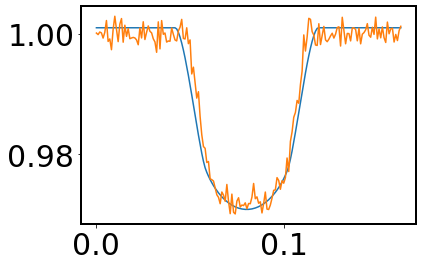

In [61]:
ans = tf.transitmodel(sol, photospectra[5].time, itime=photospectra[5].itime, \
                                       ntt=tpars.ntt, tobs=tpars.tobs, omc=tpars.omc)

plt.figure()
plt.plot(photospectra[5].time, ans)
plt.plot(photospectra[5].time, photospectra[5].flux)
plt.show()

In [91]:
corscale = betarescale(x, beta, niter_cor, burnin_cor, mhgmcmc, loglikelihood=lnprob, imax=0)

<ipython-input-47-0859c60a2ac9>:260: RuntimeWarning: overflow encountered in exp
  alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability


Current Acceptance:  [0.40540541 0.62857143 0.42857143 0.48       0.46875    0.5
 0.46875    0.32352941 0.55172414 0.5        0.57894737 0.5
 0.625      0.42857143 0.48387097 0.51428571 0.55555556 0.5483871
 0.51724138 0.57142857 0.58333333 0.5862069  0.46428571 0.53125
 0.57142857 0.57575758 0.3125     0.48648649 0.67857143 0.47368421
 0.5        0.45454545 0.51428571 0.5        0.35714286 0.52941176
 0.76190476 0.63888889 0.51515152 0.53846154 0.43333333 0.48275862
 0.5        0.43333333 0.37142857 0.44       0.48387097 0.53488372
 0.54545455 0.44444444 0.4375     0.4        0.46875    0.56410256
 0.48387097 0.41176471 0.5        0.46666667 0.5862069  0.61111111
 0.56756757 0.5483871  0.4        0.47058824 0.63157895 0.45454545
 0.59459459 0.31428571 0.42857143 0.34285714 0.41025641 0.53846154
 0.46875    0.44117647 0.5625     0.54545455 0.48148148 0.53571429
 0.58823529 0.55555556 0.58333333 0.44117647 0.42222222 0.41463415
 0.5625     0.46428571 0.48571429 0.63157895 0.42424242 0.5

In [92]:
nloop = 0
nsteps = np.copy(nsteps1)
mcmcloop = True
while mcmcloop==True:

    nloop += 1   # Count number of loops

    hchain1,haccept1 = genchain(x, nsteps, beta*corscale, mhgmcmc, lnprob)
    hchain2,haccept2 = genchain(x, nsteps, beta*corscale, mhgmcmc, lnprob)
    hchain3,haccept3 = genchain(x, nsteps, beta*corscale, mhgmcmc, lnprob)

    if nloop==1:
        chain1 = np.copy(hchain1)
        chain2 = np.copy(hchain2)
        chain3 = np.copy(hchain3)
        accept1 = np.copy(haccept1)
        accept2 = np.copy(haccept2)
        accept3 = np.copy(haccept3)
    else:
        chain1 = np.concatenate((chain1, hchain1))
        chain2 = np.concatenate((chain2, hchain2))
        chain3 = np.concatenate((chain3, hchain3))
        accept1 = np.concatenate((accept1, haccept1))
        accept2 = np.concatenate((accept2, haccept2))
        accept3 = np.concatenate((accept3, haccept3))

    burnin = int(chain1.shape[0]*burninf)
    calcacrate(accept1, burnin)

    grtest = gelmanrubin(chain1, chain2, chain3, burnin=burnin, npt=len(phot.time))
    print('Gelman-Rubin Convergence:')
    print('parameter  Rc')
    for i in range(0,len(chain1[1,:])):
        print('%8s %3s %.4f' %(str(i),tran_par_names[i],grtest[i]))
    if int(np.sum(grtest[grtest<buf_converge_crit]/grtest[grtest<buf_converge_crit]))==len(grtest):
        mcmcloop = False
    else:
        mcmcloop = True
        nsteps += nsteps1

    #runtest=np.array(tf.checkperT0(chain1,burninf,TPnthin,sol,serr))
    #print('runtest:',runtest)
    #if int(np.sum(runtest[runtest<1.0]/runtest[runtest<1.0]))!=4.0:
    #    mcmcloop=False #run-away

    if nloop>=nloopmax:  # Break if too many loops
        mcmcloop = False

    #print("---- %s seconds ----" % (time.time() - start_time))

<ipython-input-47-0859c60a2ac9>:260: RuntimeWarning: overflow encountered in exp
  alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability


Global Acceptance Rate: 0.477
0 Acceptance Rate 0.468
1 Acceptance Rate 0.487
2 Acceptance Rate 0.419
3 Acceptance Rate 0.286
4 Acceptance Rate 0.444
5 Acceptance Rate 0.577
6 Acceptance Rate 0.611
7 Acceptance Rate 0.488
8 Acceptance Rate 0.513
9 Acceptance Rate 0.450
10 Acceptance Rate 0.380
11 Acceptance Rate 0.422
12 Acceptance Rate 0.581
13 Acceptance Rate 0.390
14 Acceptance Rate 0.417
15 Acceptance Rate 0.434
16 Acceptance Rate 0.475
17 Acceptance Rate 0.581
18 Acceptance Rate 0.500
19 Acceptance Rate 0.419
20 Acceptance Rate 0.450
21 Acceptance Rate 0.583
22 Acceptance Rate 0.472
23 Acceptance Rate 0.452
24 Acceptance Rate 0.595
25 Acceptance Rate 0.512
26 Acceptance Rate 0.426
27 Acceptance Rate 0.411
28 Acceptance Rate 0.476
29 Acceptance Rate 0.342
30 Acceptance Rate 0.650
31 Acceptance Rate 0.500
32 Acceptance Rate 0.486
33 Acceptance Rate 0.520
34 Acceptance Rate 0.341
35 Acceptance Rate 0.486
36 Acceptance Rate 0.447
37 Acceptance Rate 0.344
38 Acceptance Rate 0.525
39 Ac

103 Acceptance Rate 0.146
104 Acceptance Rate 0.155
105 Acceptance Rate 0.208
106 Acceptance Rate 0.134
107 Acceptance Rate 0.092
108 Acceptance Rate 0.176
109 Acceptance Rate 0.188
110 Acceptance Rate 0.257
111 Acceptance Rate 0.186
112 Acceptance Rate 0.095
113 Acceptance Rate 0.182
114 Acceptance Rate 0.202
115 Acceptance Rate 0.270
116 Acceptance Rate 0.206
117 Acceptance Rate 0.161
118 Acceptance Rate 0.224
119 Acceptance Rate 0.217
120 Acceptance Rate 0.172
121 Acceptance Rate 0.091
122 Acceptance Rate 0.209
123 Acceptance Rate 0.521
Gelman-Rubin Convergence:
parameter  Rc
       0   p 1.0245
       1  q1 1.0672
       2  q1 1.1833
       3  q1 1.1389
       4  q1 1.0396
       5  q1 1.2127
       6  q1 1.3877
       7  q1 1.3423
       8  q1 1.0506
       9  q1 1.0674
      10  q1 1.0477
      11  q1 1.0563
      12  q1 1.0670
      13  q1 1.0487
      14  q1 1.0923
      15  q1 1.2037
      16  q1 1.0210
      17  q1 1.3461
      18  q1 1.1455
      19  q1 1.0843
      20  q1 1

In [93]:
mcmcloop = True
nloop = 0
nsteps = np.copy(nsteps2)
while mcmcloop==True:

    nloop += 1  # Count number of loops

    burnin = int(chain1.shape[0]*burninf)
    buffer = np.concatenate((chain1[burnin:],chain2[burnin:],chain3[burnin:]))  # Create buffer for deMCMC
    x1 = np.copy(chain1[chain1.shape[0]-1,:])
    x2 = np.copy(chain1[chain1.shape[0]-1,:])
    x3 = np.copy(chain1[chain1.shape[0]-1,:])
    corbeta = 0.3
    burnin = int(chain1.shape[0]*burninf)
    chain1, accept1 = genchain(x1,nsteps,beta*corscale,demhmcmc,lnprob,buffer=buffer,\
                              corbeta=corbeta,progress=True)
    chain2, accept2 = genchain(x2,nsteps,beta*corscale,demhmcmc,lnprob,buffer=buffer,\
                              corbeta=corbeta,progress=True)
    chain3, accept3 = genchain(x3,nsteps,beta*corscale,demhmcmc,lnprob,buffer=buffer,\
                              corbeta=corbeta,progress=True)

    burnin = int(chain1.shape[0]*burninf)
    grtest = gelmanrubin(chain1,chain2,chain3,burnin=burnin,npt=len(phot.time))
    print('Gelman-Rubin Convergence:')
    print('parameter  Rc')
    for i in range(0,len(chain1[1,:])):
        print('%8s %3s %.4f' %(str(i),tran_par_names[i],grtest[i]))

    if int(np.sum(grtest[grtest<converge_crit]/grtest[grtest<converge_crit]))==len(grtest):
        mcmcloop = False
    else:
        mcmcloop = True

    burnin = int(chain1.shape[0]*burninf)
    chain = np.concatenate((chain1[burnin:,],chain2[burnin:,],chain3[burnin:,]))
    accept = np.concatenate((accept1[burnin:,],accept2[burnin:,],accept3[burnin:,]))
    burnin = int(chain.shape[0]*burninf)
    calcacrate(accept,burnin)

    nsteps += nsteps_inc  # Make longer chain to help with convergence

    ##check for run-away Chain.
    #runtest=np.array(tf.checkperT0(chain1,burninf,nthin,sol,serr))
    #print('runtest:',runtest)
    #if int(np.sum(runtest[runtest<1.0]/runtest[runtest<1.0]))!=4.0:
    #    mcmcloop=False #run-away

    if nloop>=nloopmax:   # Break if too many loops
        mcmcloop = False

    #print("---- %s seconds ----" % (time.time() - start_time))

#print("done %s seconds ---" % (time.time() - start_time))

<ipython-input-47-0859c60a2ac9>:71: RuntimeWarning: overflow encountered in exp
  alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability


<ipython-input-47-0859c60a2ac9>:39: RuntimeWarning: divide by zero encountered in true_divide
  Rc = np.sqrt((dof+3.0)/(dof+1.0)*V/W)   # PSRF from Brooks and Gelman (1997)


Gelman-Rubin Convergence:
parameter  Rc
       0   p 14.9814
       1  q1 1.5446
       2  q1 2.1975
       3  q1 1.4947
       4  q1 5.1467
       5  q1 2.2959
       6  q1 38140743108.3137
       7  q1 1.2708
       8  q1 11178983900.4128
       9  q1 1.1099
      10  q1 21465951553.2163
      11  q1 2.4772
      12  q1 6028743733.7289
      13  q1 1.1044
      14  q1 12391837701.0760
      15  q1 77113039607.4368
      16  q1 16776084772.5870
      17  q1 2.8201
      18  q1 2.0483
      19  q1 2.5631
      20  q1 1.2437
      21  q1 1.0969
      22  q1 1.9842
      23  q1 36.5324
      24  q1 1.8258
      25  q1 1.1574
      26  q1 2.4047
      27  q1 61.2243
      28  q1 1.5481
      29  q1 1.1343
      30  q1 2.2804
      31  q2 1.2549
      32  q2 35447680232.2828
      33  q2 1.1997
      34  q2 2.6561
      35  q2 2.5561
      36  q2 2.3875
      37  q2 3.9921
      38  q2 167183494085.7151
      39  q2 3.0345
      40  q2 29691416593.0369
      41  q2 1.1538
      42  q2 1.69

<ipython-input-47-0859c60a2ac9>:39: RuntimeWarning: invalid value encountered in true_divide
  Rc = np.sqrt((dof+3.0)/(dof+1.0)*V/W)   # PSRF from Brooks and Gelman (1997)


Gelman-Rubin Convergence:
parameter  Rc
       0   p 9.3535
       1  q1 50206562394.6130
       2  q1 4.5678
       3  q1 7230830654.0114
       4  q1 4.6240
       5  q1 412066101.7295
       6  q1 2.8589
       7  q1 4226104012.8248
       8  q1 1.4523
       9  q1 1040781137.8908
      10  q1 3.0657
      11  q1 2.6514
      12  q1 4.1548
      13  q1 1605307001.6069
      14  q1 34.1355
      15  q1 1.3659
      16  q1 3874270823.3806
      17  q1 13787292790.8573
      18  q1 2.2294
      19  q1 8831406385.8006
      20  q1 1129795483.0606
      21  q1 56124529237.1673
      22  q1 4785185153.5449
      23  q1 6.2851
      24  q1 2956032025.1147
      25  q1 1.0095
      26  q1 1.6962
      27  q1 6.8074
      28  q1 1.5196
      29  q1 2.1872
      30  q1 1.7348
      31  q2 1815893826.1602
      32  q2 9.0785
      33  q2 2954191349.4367
      34  q2 37599417100.2319
      35  q2 6.3220
      36  q2 2.0412
      37  q2 2835337381.5549
      38  q2 6712898442.0839
      39  q2 1


Gelman-Rubin Convergence:
parameter  Rc
       0   p 7.1932
       1  q1 6.0467
       2  q1 1.0633
       3  q1 1.0054
       4  q1 1.0893
       5  q1 1.2517
       6  q1 1.5275
       7  q1 1.0449
       8  q1 2514112921.8295
       9  q1 1.3697
      10  q1 9622180391.6526
      11  q1 810276871.8255
      12  q1 2973081776.7240
      13  q1 2.0672
      14  q1 21.7403
      15  q1 2.5274
      16  q1 1.0237
      17  q1 18.0371
      18  q1 3.6924
      19  q1 4.0635
      20  q1 31258996478.6171
      21  q1 1.1927
      22  q1 8.6292
      23  q1 6.1208
      24  q1 1499787922.9521
      25  q1 1.2421
      26  q1 1.4580
      27  q1 3.2641
      28  q1 517093459.8615
      29  q1 4.9332
      30  q1 5.3046
      31  q2 2.2767
      32  q2 12.1010
      33  q2 970330517.6709
      34  q2 2.4541
      35  q2 28066182.2011
      36  q2 633344785.5550
      37  q2 5.4298
      38  q2 6.6917
      39  q2 1.1249
      40  q2 5768800636.2280
      41  q2 11.0757
      42  q2 2.7961
 


Gelman-Rubin Convergence:
parameter  Rc
       0   p 1.5351
       1  q1 1.7327
       2  q1 1.1281
       3  q1 1.0054
       4  q1 1.1007
       5  q1 4.6290
       6  q1 3089583541.2691
       7  q1 5.7314
       8  q1 215110338.1421
       9  q1 1.0666
      10  q1 2449407242.4166
      11  q1 84967426.3385
      12  q1 160796324.2853
      13  q1 2.2291
      14  q1 1.0605
      15  q1 4.0553
      16  q1 18.0041
      17  q1 1.1748
      18  q1 1.3096
      19  q1 2.1521
      20  q1 19.5379
      21  q1 1.5994
      22  q1 4777564425.2127
      23  q1 1.9377
      24  q1 332300035.8098
      25  q1 2.2438
      26  q1 1.0201
      27  q1 1.2459
      28  q1 23.8998
      29  q1 3.2414
      30  q1 1.7011
      31  q2 1.6702
      32  q2 16.3908
      33  q2 1.0054
      34  q2 1.2850
      35  q2 845296395.9595
      36  q2 2267826992.0777
      37  q2 1.2339
      38  q2 1.7375
      39  q2 6.3880
      40  q2 1698831113.9871
      41  q2 7.1693
      42  q2 1.0480
      43  q


Gelman-Rubin Convergence:
parameter  Rc
       0   p 1.1133
       1  q1 1.2234
       2  q1 1.0056
       3  q1 1.4588
       4  q1 1.0081
       5  q1 4.7427
       6  q1 3222027192.2775
       7  q1 1.2770
       8  q1 1.0054
       9  q1 1.1207
      10  q1 2592412812.3605
      11  q1 1.0054
      12  q1 2.6450
      13  q1 1.4930
      14  q1 1.6479
      15  q1 1.1184
      16  q1 1.6019
      17  q1 1.0451
      18  q1 1.0684
      19  q1 1.0726
      20  q1 3.9718
      21  q1 1.9943
      22  q1 1.0054
      23  q1 1.1427
      24  q1 1.0054
      25  q1 4.4342
      26  q1 1.0182
      27  q1 3.8268
      28  q1 25.0582
      29  q1 11.5828
      30  q1 1.0937
      31  q2 2.7375
      32  q2 2.0367
      33  q2 3457511778.3390
      34  q2 1.0119
      35  q2 2.1413
      36  q2 1.0054
      37  q2 2.5831
      38  q2 1.0253
      39  q2 1.7642
      40  q2 8.9645
      41  q2 5.6434
      42  q2 1.0324
      43  q2 1.0054
      44  q2 1.1230
      45  q2 1.0401
      46  

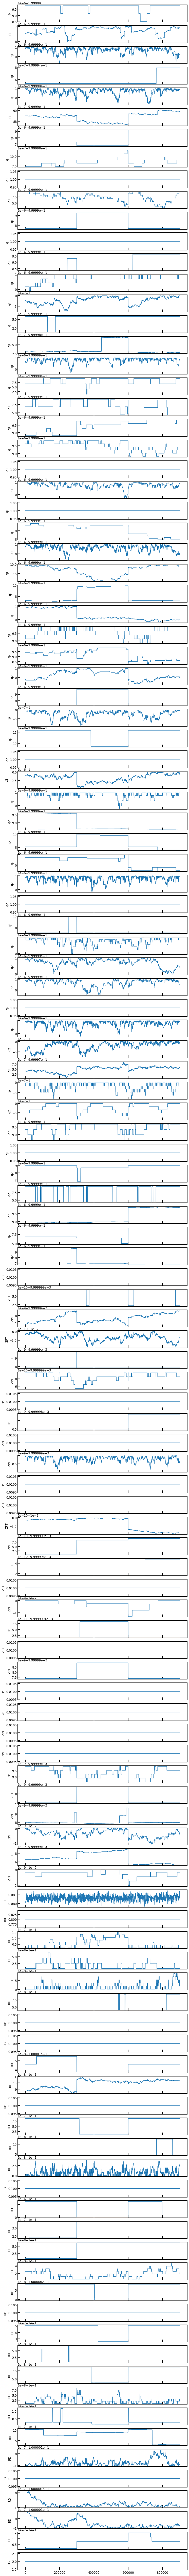

In [94]:
matplotlib.rcParams.update({'font.size': 12}) #adjust font
plotchains(chain,0,tran_par_names)

In [95]:
npars = len(chain[1,:])
mm = np.zeros(npars)
for i in range(0, npars):
    mode,x_eval,kde1 = tf.modekdestimate(chain[::10,i],0)
    mm[i] = mode
    perc1 = tf.intperc(mode,x_eval,kde1)#,perc=0.997)
    print('%s = %.8f +%.8f -%.8f (1 Sigma)' %(tran_par_names[i],mode,np.abs(perc1[1]-mode),np.abs(mode-perc1[0])))

p = 5.99999978 +0.00000000 -0.00000125 (1 Sigma)
q1 = 0.99999977 +0.00000023 -0.00000056 (1 Sigma)
q1 = 0.99999994 +0.00000006 -0.00000035 (1 Sigma)
q1 = 0.99999454 +0.00000026 -0.00000000 (1 Sigma)
q1 = 0.99999995 +0.00000004 -0.00000048 (1 Sigma)
q1 = 0.99999893 +0.00000009 -0.00000012 (1 Sigma)
q1 = 0.99999730 +0.00000191 -0.00000056 (1 Sigma)
q1 = 0.99999890 +0.00000004 -0.00000009 (1 Sigma)
q1 = 0.99999963 +0.00000000 -0.00000000 (1 Sigma)
q1 = 0.99999975 +0.00000017 -0.00000016 (1 Sigma)
q1 = 0.99999768 +0.00000159 -0.00000000 (1 Sigma)
q1 = 0.99999924 +0.00000000 -0.00000000 (1 Sigma)
q1 = 0.99999838 +0.00000125 -0.00000000 (1 Sigma)
q1 = 0.99999995 +0.00000000 -0.00000104 (1 Sigma)
q1 = 0.99999996 +0.00000003 -0.00000031 (1 Sigma)
q1 = 0.99999958 +0.00000000 -0.00000045 (1 Sigma)
q1 = 0.99999830 +0.00000003 -0.00000003 (1 Sigma)
q1 = 0.99999992 +0.00000007 -0.00000024 (1 Sigma)
q1 = 0.99999996 +0.00000000 -0.00000085 (1 Sigma)
q1 = 0.99999990 +0.00000000 -0.00000043 (1 Sigma)
q

LinAlgError: singular matrix

In [20]:
npars = len(chain[1,:])
mm = np.zeros(npars)

nthin = 10
chain_thin = chain[::nthin,:]


rprs_model = []
rprs_model_ep = []
rprs_model_em = []
for i in range(93,123):
    mode, x_eval, kde1 = tf.modekdestimate(chain_thin[:,i], 0)
    mm[i] = mode
    perc1 = tf.intperc(mode, x_eval, kde1) #, perc=0.997)
    rprs_model.append(mode)
    rprs_model_ep.append( np.abs(perc1[1]-mode))
    rprs_model_em.append(-np.abs(mode-perc1[0]))
    print('%s = %.8f +%.8f -%.8f (1 Sigma)' %(tran_par_names[i],mode,np.abs(perc1[1]-mode),np.abs(mode-perc1[0])))
    
rprs_model = np.array(rprs_model)
rprs_model_ep = np.array(rprs_model_ep)
rprs_model_em = np.array(rprs_model_em)

RD = 0.16000000 +0.00000001 -0.00000000 (1 Sigma)


LinAlgError: singular matrix

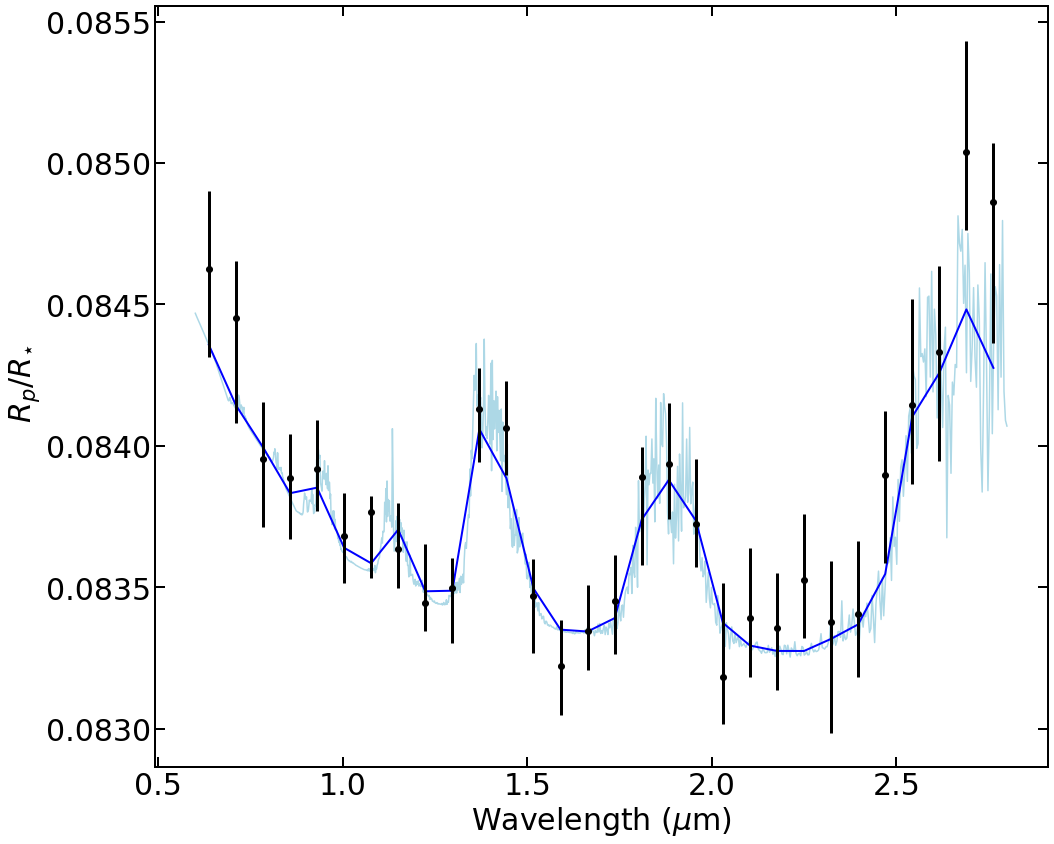

In [30]:
matplotlib.rcParams.update({'font.size': 30})  # Adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig = plt.figure(figsize=(16,14))  # Adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)

ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_xlabel('Wavelength ($\mu$m)')
ax.set_ylabel('$R_{p}/R_{\star}$')


#rprs_binned=np.array([0.08425564673418401, 0.08391695345274379, 0.08375053190856288, 0.08364267099710652, \
#                     0.08348632677920928, 0.083973083683014,   0.08342468358830134, 0.08336638722554368, \
#                     0.08380774401419508, 0.08355463168731934, 0.0832839245500194,  0.08329519340547527, \
#                     0.08345741726828987, 0.08418017555669018, 0.08437886537394856])

# Get wavelength and transit depth info
psg_model.wavelength = np.array([float(d[0]) for d in model_data])  # Wavelength in microns 
# psg_model.Rp = np.array([d[1]*1000 for d in model_data])  # This is in m and is contribution of atmosphere
psg_model.RpRs = np.array([np.sqrt(float(d[1])/1.0e6) for d in model_data])  # Transit depth 
# psg_model.Rp_err = np.array([d[2] for d in model_data]) 

# ax.plot(psg_model.wavelength,(psg_model.Rp+Rp_m)/Rs_m,c='lightblue',zorder=0)
ax.plot(psg_model.wavelength, psg_model.RpRs,c='lightblue',zorder=0)
#ax.plot(tpars.wavelength,rprs_binned,zorder=1,c='blue',lw=2)

ax.errorbar(tpars.wavelength,rprs_model*0.99+0.001,np.array([-rprs_model_em,rprs_model_ep]),fmt='o',lw=3,c='black',\
            zorder=2)

fig.show()

In [ ]:
#Corner is SLOW
#figure = corner.corner(chain,quantiles=[0.16, 0.5, 0.84],show_titles=True,labels=tran_par_names)